In [3]:
#%matplotlib widget

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

from Wine_Quality.custom_funcs import MultipleFisherDiscriminantAnalysis as MDA

In [4]:
red_wine = pd.read_csv('../data/cleaned/winequality-red.csv', sep=';', header=None).drop(0)

col_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality' ]
rename_dict = {k: col_names[k] for k in range(12)}
red_wine.rename(columns=rename_dict, inplace=True)

#red_wine.sort_values('quality', inplace=True)
#red_wine.reset_index(drop=True, inplace=True)

red_wine = red_wine.apply(pd.to_numeric) # convert all columns of DataFrame


In [5]:
colors_numbers1 = [3, 4, 5, 6, 7, 8]
colors1 = ['red', 'orange', 'yellow', 'lime', 'deepskyblue', 'blue']
quality1 = red_wine.iloc[:, -1].copy()
quality1.replace(colors_numbers1, value=colors1, inplace=True)


,counts,freq.
class,,
3,10,0.006254
4,53,0.033146
5,681,0.425891
6,638,0.398999
7,199,0.124453
8,18,0.011257


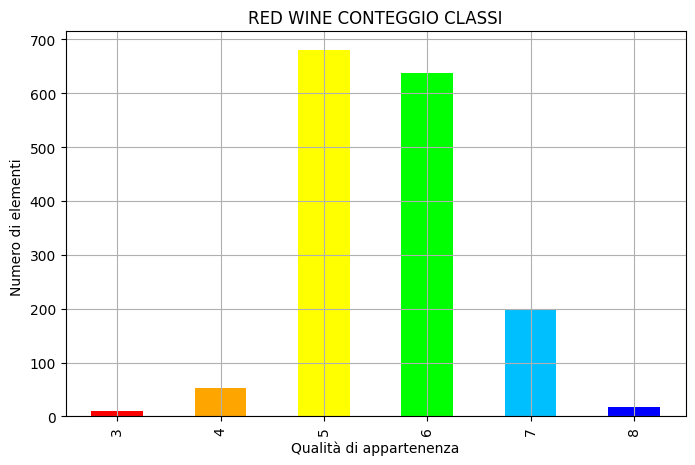

In [6]:
M1, N1 = red_wine.shape
class_cont_freq = pd.concat([red_wine['quality'].value_counts(), red_wine['quality'].value_counts()/M1], axis=1)
class_cont_freq.columns = ['counts', 'freq.']  
class_cont_freq.index.name = 'class'
class_cont_freq.sort_values('class', inplace=True)

display(class_cont_freq)

plt.figure()
class_cont_freq['counts'].plot.bar(figsize=(8,5), color=['red', 'orange', 'yellow', 'lime', 'deepskyblue', 'blue'])
plt.title('RED WINE CONTEGGIO CLASSI')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()
plt.show()

# CREAZIONE TRAINING, VALIDATION E TEST SET

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [107]:
red_wine_copy = red_wine.copy()

X = red_wine_copy.iloc[:, :-1].values
y = red_wine_copy['quality'].values
y_nomi_classe = ['classe 0', 'classe 1']

random_state = 20210526
test_p = 0.5
val_p = 0.4
indices = np.arange(X.shape[0])

ind_train, ind_test = train_test_split(indices, test_size=test_p, random_state=random_state, shuffle=True)
ind_train, ind_val = train_test_split(ind_train, test_size=val_p, random_state=random_state, shuffle=True)

In [108]:
M1, N1 = red_wine.loc[ind_train+1, ['quality']].shape
M2, N2 = red_wine.loc[ind_test+1, ['quality']].shape
M3, N3 = red_wine.loc[ind_test+1, ['quality']].shape

class_cont_freq_tr = pd.concat([red_wine.loc[ind_train+1, ['quality']].value_counts(), red_wine.loc[ind_train+1, ['quality']].value_counts()/M1], axis=1)
class_cont_freq_tr.columns = ['counts', 'freq.']  
class_cont_freq_tr.index.names = ['class']
class_cont_freq_tr.sort_values('class', inplace=True)

class_cont_freq_te = pd.concat([red_wine.loc[ind_test+1, ['quality']].value_counts(), red_wine.loc[ind_test+1, ['quality']].value_counts()/M2], axis=1)
class_cont_freq_te.columns = ['counts', 'freq.']  
class_cont_freq_te.index.names = ['class']
class_cont_freq_te.sort_values('class', inplace=True)

class_cont_freq_va = pd.concat([red_wine.loc[ind_val+1, ['quality']].value_counts(), red_wine.loc[ind_val+1, ['quality']].value_counts()/M3], axis=1)
class_cont_freq_va.columns = ['counts', 'freq.']  
class_cont_freq_va.index.names = ['class']
class_cont_freq_va.sort_values('class', inplace=True)

display(class_cont_freq_tr)
display(class_cont_freq_te)
display(class_cont_freq_va)


,counts,freq.
class,,
3,2,0.004175
4,15,0.031315
5,209,0.436326
6,179,0.373695
7,68,0.141962
8,6,0.012526


,counts,freq.
class,,
3,7,0.00875
4,27,0.03375
5,336,0.42000
6,320,0.40000
7,104,0.13000
8,6,0.00750


,counts,freq.
class,,
3,1,0.00125
4,11,0.01375
5,136,0.17000
6,139,0.17375
7,27,0.03375
8,6,0.00750
